# TME 6 MOCKUS - SENYUZ


### Q1 - Implementation de C-moyennes floues et possibilistes

imports and simple 2D gaussian data

In [2]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd

import dice_ml
import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
import torch.nn.functional as F
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
import pylab



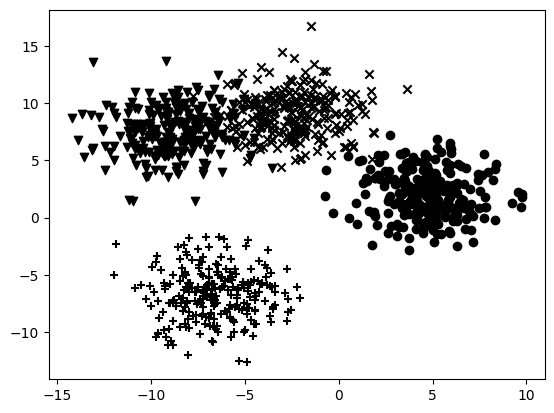

In [3]:
NB_classes = 4
markers = ['x', 'o', '+', "v", "*"]
data, labels = datasets.make_blobs(n_samples=1000, centers = NB_classes, shuffle=True, random_state=42, cluster_std = 2)

dic = {'x':data[:,0], 'y' : data[:,1], 'target': labels}
df = pd.DataFrame(data = dic)
for i in range(NB_classes):
    plt.scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'black')

Implementation of fuzzy c-means, calc_U function is separated to use in plotting level lines.

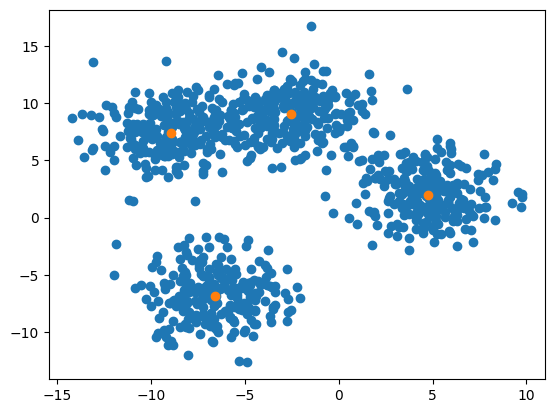

In [4]:
def calc_U(c, m , centers, X, U):
    N = X.shape[1]
    M = X.shape[0] 
    for i in range(M):
            for r in range(c):
                d_ir = (np.linalg.norm(X[i] - centers[r]))
                if d_ir == 0: 
                    U[i,:] = 0
                    U[i,r] = 1
                    break
                d_sum = 0        
                for s in range(c):
                    d_is = (np.linalg.norm(X[i] - centers[s]))
                    if d_is == 0:
                        break
                    d_sum += (d_ir / d_is) ** (2/(m-1))
                U[i,r] = 1 / d_sum
    return U

def fuzzy_c_means(c, m, X, eps, max_iter = 5):
    # init centres:
    N = X.shape[1] # space Dimension
    M = X.shape[0] # Data Length
    centers = np.random.uniform(low= np.min(X), high=np.max(X), size=(c,N)) # Number of Centers * N
    U = np.ones((M, c)) # Long x centers 
    old_centers = np.zeros_like(centers)
    for k in range(max_iter):
        old_centers = centers.copy()
        # Update u matrix:
        U = calc_U(c, m , centers, X, U)
        # Update Centers
        for r in range(c):
            uir = np.zeros_like(X[0])
            for i in range(M): 
                uir += U[i,r]**m * X[i]
            centers[r] = uir / np.sum(U[:,r]**m)
        center_distances = np.linalg.norm(old_centers - centers) 
        #print(f" Iterations : {k} , center_dist : {center_distances}")
        
        if center_distances < eps:
            break
        
    return centers, U
        
centers, U = fuzzy_c_means(4, 2, data, 0.001, max_iter = 100)
plt.scatter(data.T[0],data.T[1])
plt.scatter(centers[:,0], centers[:,1])

    

Implementation of probabilistic c-means, etas are calculated using the U matrix obtained by fuzzy C-means

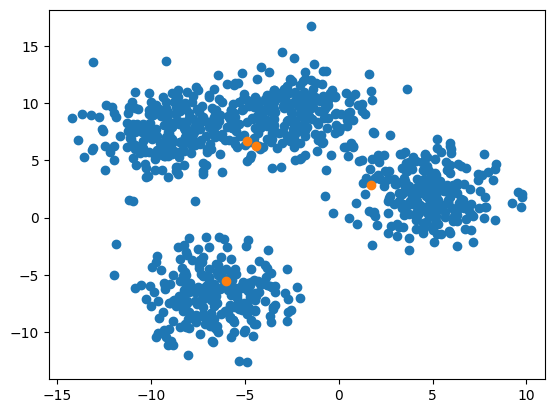

In [5]:
def calcul_eta(U, centers, X, m):
    c = centers.shape[0]
    N = X.shape[1] # Dimension de l'espace 
    M = X.shape[0] # Longeur des donees
    eta = np.zeros(c)
    for r in range(c):
        eta[r] = np.sum([U[i,r]**m * np.linalg.norm(X[i] - centers[r])**2 for i in range(M)]) / np.sum(U[:,r]**m)
    return eta

def calc_U_proba(c, m , centers, X, eta, U):
    N = X.shape[1]
    M = X.shape[0]
    for i in range(M):
        for r in range(c):
            U[i,r] = 1 / (1 + ((np.linalg.norm(X[i] - centers[r])) / eta[r])**(2/(m-1)))
        U[i] /= np.sum(U[i])
    return U

def proba_c_means(c, m, X, eta, eps, max_iter = 5):
    # init centres:
    N = X.shape[1] # Dimension de l'espace 
    M = X.shape[0] # Longeur des donees
    centers = np.random.uniform(low= np.min(X), high=np.max(X), size=(c,N)) # centers * N
    U = np.ones((M, c)) # Long x centers 
    old_centers = np.zeros_like(centers)
    for k in range(max_iter):
        old_centers = centers.copy()
        # caclul matrice U:
        U = calc_U_proba(c, m , centers, X, eta, U)
        for r in range(c):
            uir = np.zeros_like(X[0])
            for i in range(M): 
                uir += U[i,r]**m * X[i]
            centers[r] = uir / np.sum(U[:,r]**m)
        center_distances = np.linalg.norm(old_centers - centers) 
        #print(f" Iterations : {k} , center_dist : {center_distances}")
        
        if center_distances < eps:
            break
        
    return centers, U
        
    
eta = calcul_eta(U, centers, data, 2)
centers_p, U_p = proba_c_means(4, 2, data, eta, 0.001, max_iter = 100)
plt.scatter(data.T[0],data.T[1])
plt.scatter(centers_p[:,0], centers_p[:,1])

### Q2 - Comparison of Fuzzy c-means, probabilistic c-means and 

In [6]:
x = np.linspace(-20.0, 20.0)
y = np.linspace(-20.0, 20.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

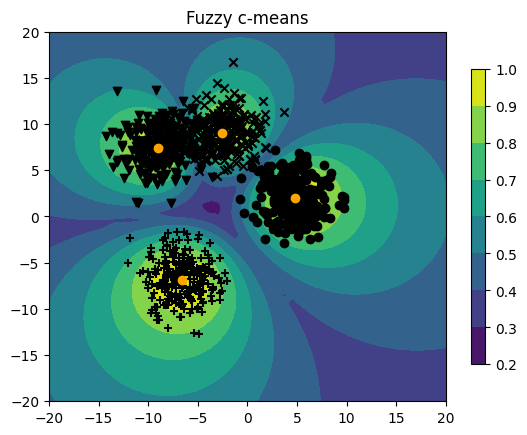

In [11]:
U = np.ones((XX.shape[0], NB_classes))
Z = np.max(calc_U(4, 2 , centers, XX, U), axis = 1)
Z = Z.reshape(X.shape)
CS = plt.contourf(
    X, Y, Z
)
for i in range(NB_classes):
    plt.scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'black')
plt.scatter(centers[:,0], centers[:,1], color = 'orange')
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.title("Fuzzy c-means")


plt.show()

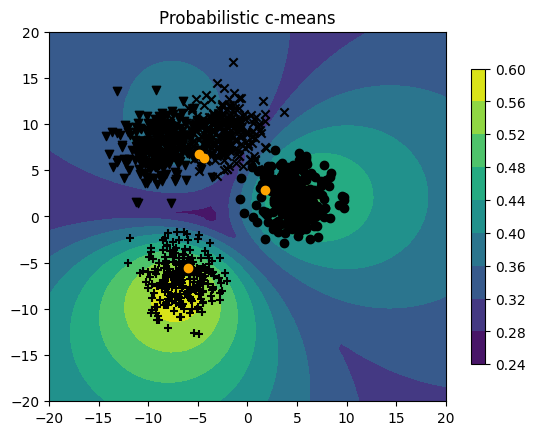

In [10]:
U = np.ones((XX.shape[0], NB_classes))
Z = np.max(calc_U_proba(4, 2 , centers_p, XX, eta, U), axis = 1)
Z = Z.reshape(X.shape)
CS = plt.contourf(
    X, Y, Z
)
for i in range(NB_classes):
    plt.scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'black')
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(centers_p[:,0], centers_p[:,1], color = 'orange')
plt.title("Probabilistic c-means")


plt.show()

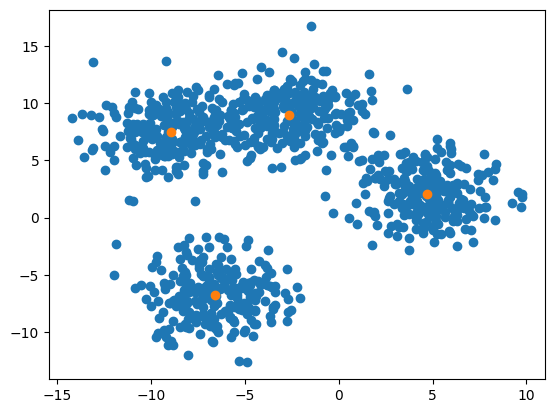

In [40]:
gm = GaussianMixture(n_components=NB_classes, random_state=42).fit(data)
plt.scatter(data.T[0],data.T[1])
plt.scatter(gm.means_[:,0], gm.means_[:,1])

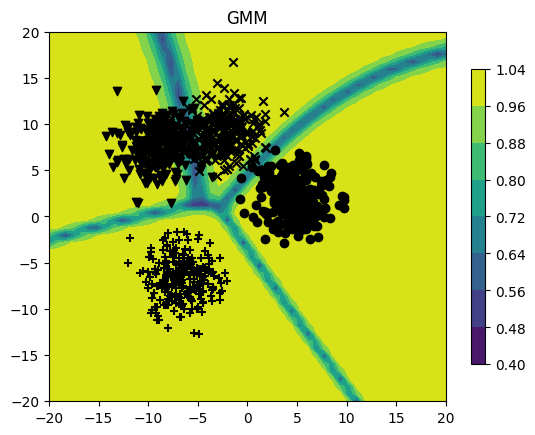

In [41]:
pred = gm.predict_proba(XX)
Z = np.max(gm.predict_proba(XX), axis = 1)
Z = Z.reshape(X.shape)
CS = plt.contourf(
    X, Y, Z
)
for i in range(NB_classes):
    plt.scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'black')
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.title("GMM")

plt.show()

### Q3 - Non Gaussian Data

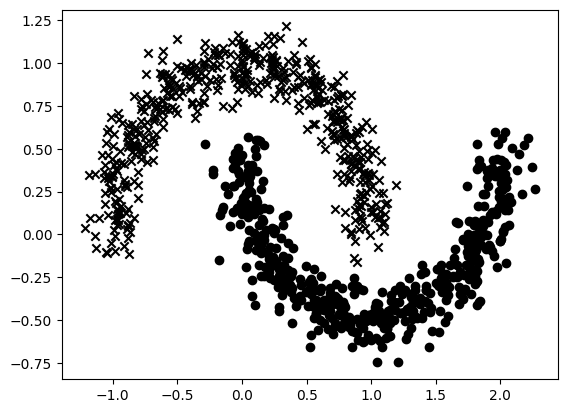

In [13]:
NB_classes = 2
markers = ['x', 'o', '+', "v", "*"]
data, labels = datasets.make_moons(n_samples=1000, shuffle=True, random_state=42, noise = 0.1)

dic = {'x':data[:,0], 'y' : data[:,1], 'target': labels}
df = pd.DataFrame(data = dic)
for i in range(NB_classes):
    plt.scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'black')

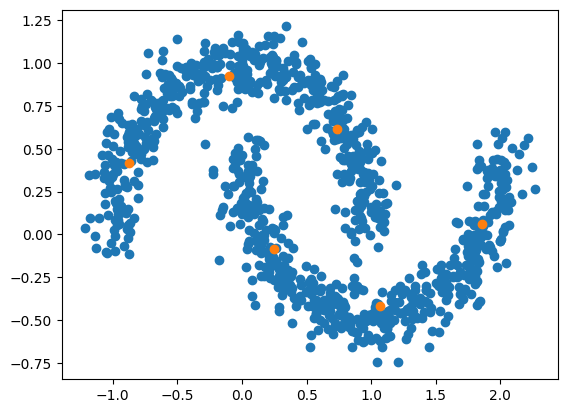

In [23]:
centers, U = fuzzy_c_means(6, 2, data, 0.0001, max_iter = 100)
plt.scatter(data.T[0],data.T[1])
plt.scatter(centers[:,0], centers[:,1])

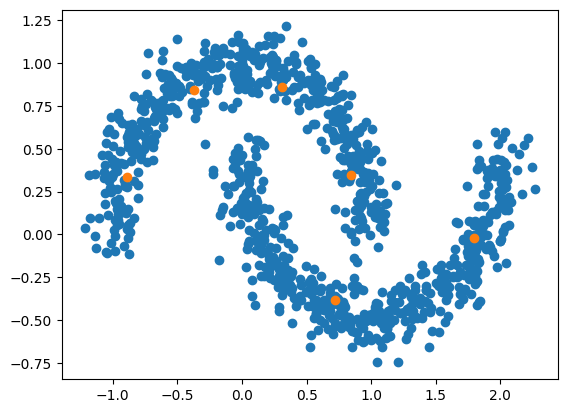

In [24]:
eta = calcul_eta(U, centers, data, 2)
centers_p, U_p = proba_c_means(6, 2, data, eta, 0.001, max_iter = 100)
plt.scatter(data.T[0],data.T[1])
plt.scatter(centers_p[:,0], centers_p[:,1])

In [25]:

x = np.linspace(-1.5, 2.5)
y = np.linspace(-1.5, 1.5)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T


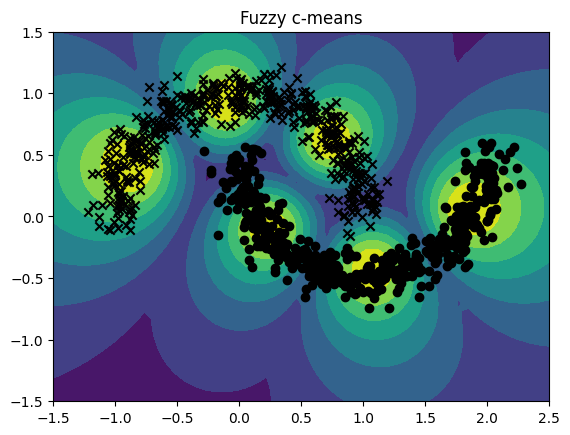

In [27]:

U = np.ones((XX.shape[0], 6))
Z = np.max(calc_U(6, 2 , centers, XX, U), axis = 1)
Z = Z.reshape(X.shape)
CS = plt.contourf(
    X, Y, Z
)
for i in range(NB_classes):
    plt.scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'black')
plt.title("Fuzzy c-means")
plt.show()


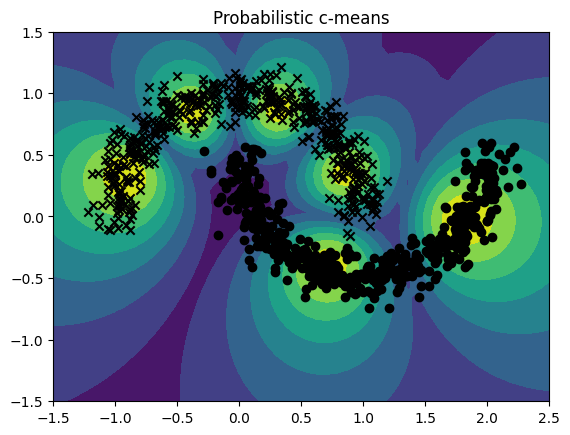

In [29]:
U = np.ones((XX.shape[0], 6))
Z = np.max(calc_U_proba(6, 2 , centers_p, XX, eta, U), axis = 1)
Z = Z.reshape(X.shape)
CS = plt.contourf(
    X, Y, Z
)
for i in range(NB_classes):
    plt.scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'black')
plt.title("Probabilistic c-means")


plt.show()

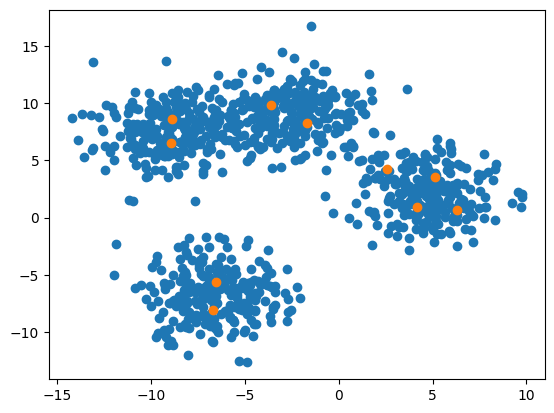

In [12]:
gm = GaussianMixture(n_components=10, random_state=42).fit(data)
plt.scatter(data.T[0],data.T[1])
plt.scatter(gm.means_[:,0], gm.means_[:,1])


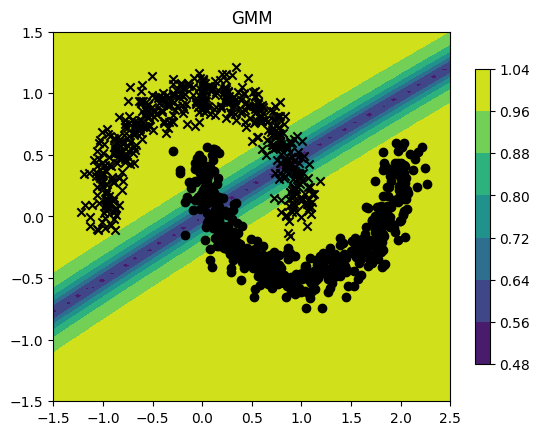

In [49]:

pred = gm.predict_proba(XX)
Z = np.max(gm.predict_proba(XX), axis = 1)
Z = Z.reshape(X.shape)
CS = plt.contourf(
    X, Y, Z
)
for i in range(NB_classes):
    plt.scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'black')
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.title("GMM")

plt.show()

AttributeError: 'AgglomerativeClustering' object has no attribute 'distances_'

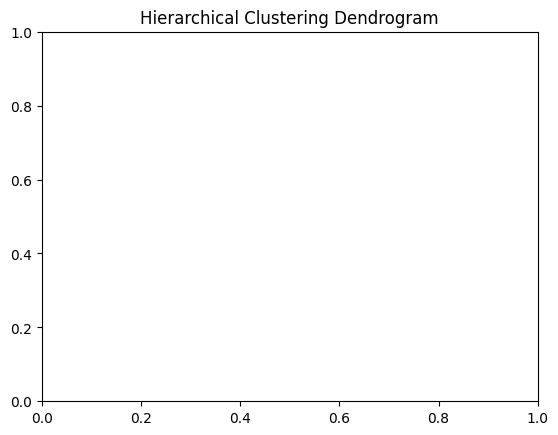

In [55]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


data, labels = datasets.make_blobs(n_samples=[50, 50] , centers = [[0, 2], [0, -2]], shuffle=True, cluster_std = 0.7, random_state= 7)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=None)

model = model.fit(data)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

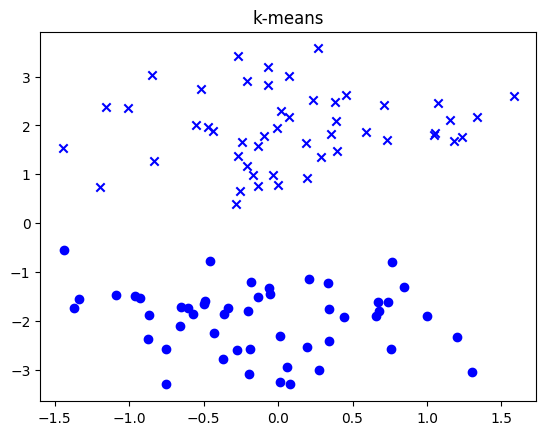

In [56]:
x = np.linspace(-3.0, 9)
y = np.linspace(-4.0, 4.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
data, labels = datasets.make_blobs(n_samples=[50, 50] , centers = [[0, 2], [0, -2]], shuffle=True, cluster_std = 0.7, random_state= 7)

ac = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(data)
labels = ac.labels_

for i in range(NB_classes):
    plt.scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'blue')
#plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], marker = "D", color = 'green')
plt.title("k-means")
plt.show()


### Q4 - Algorithm's robustness

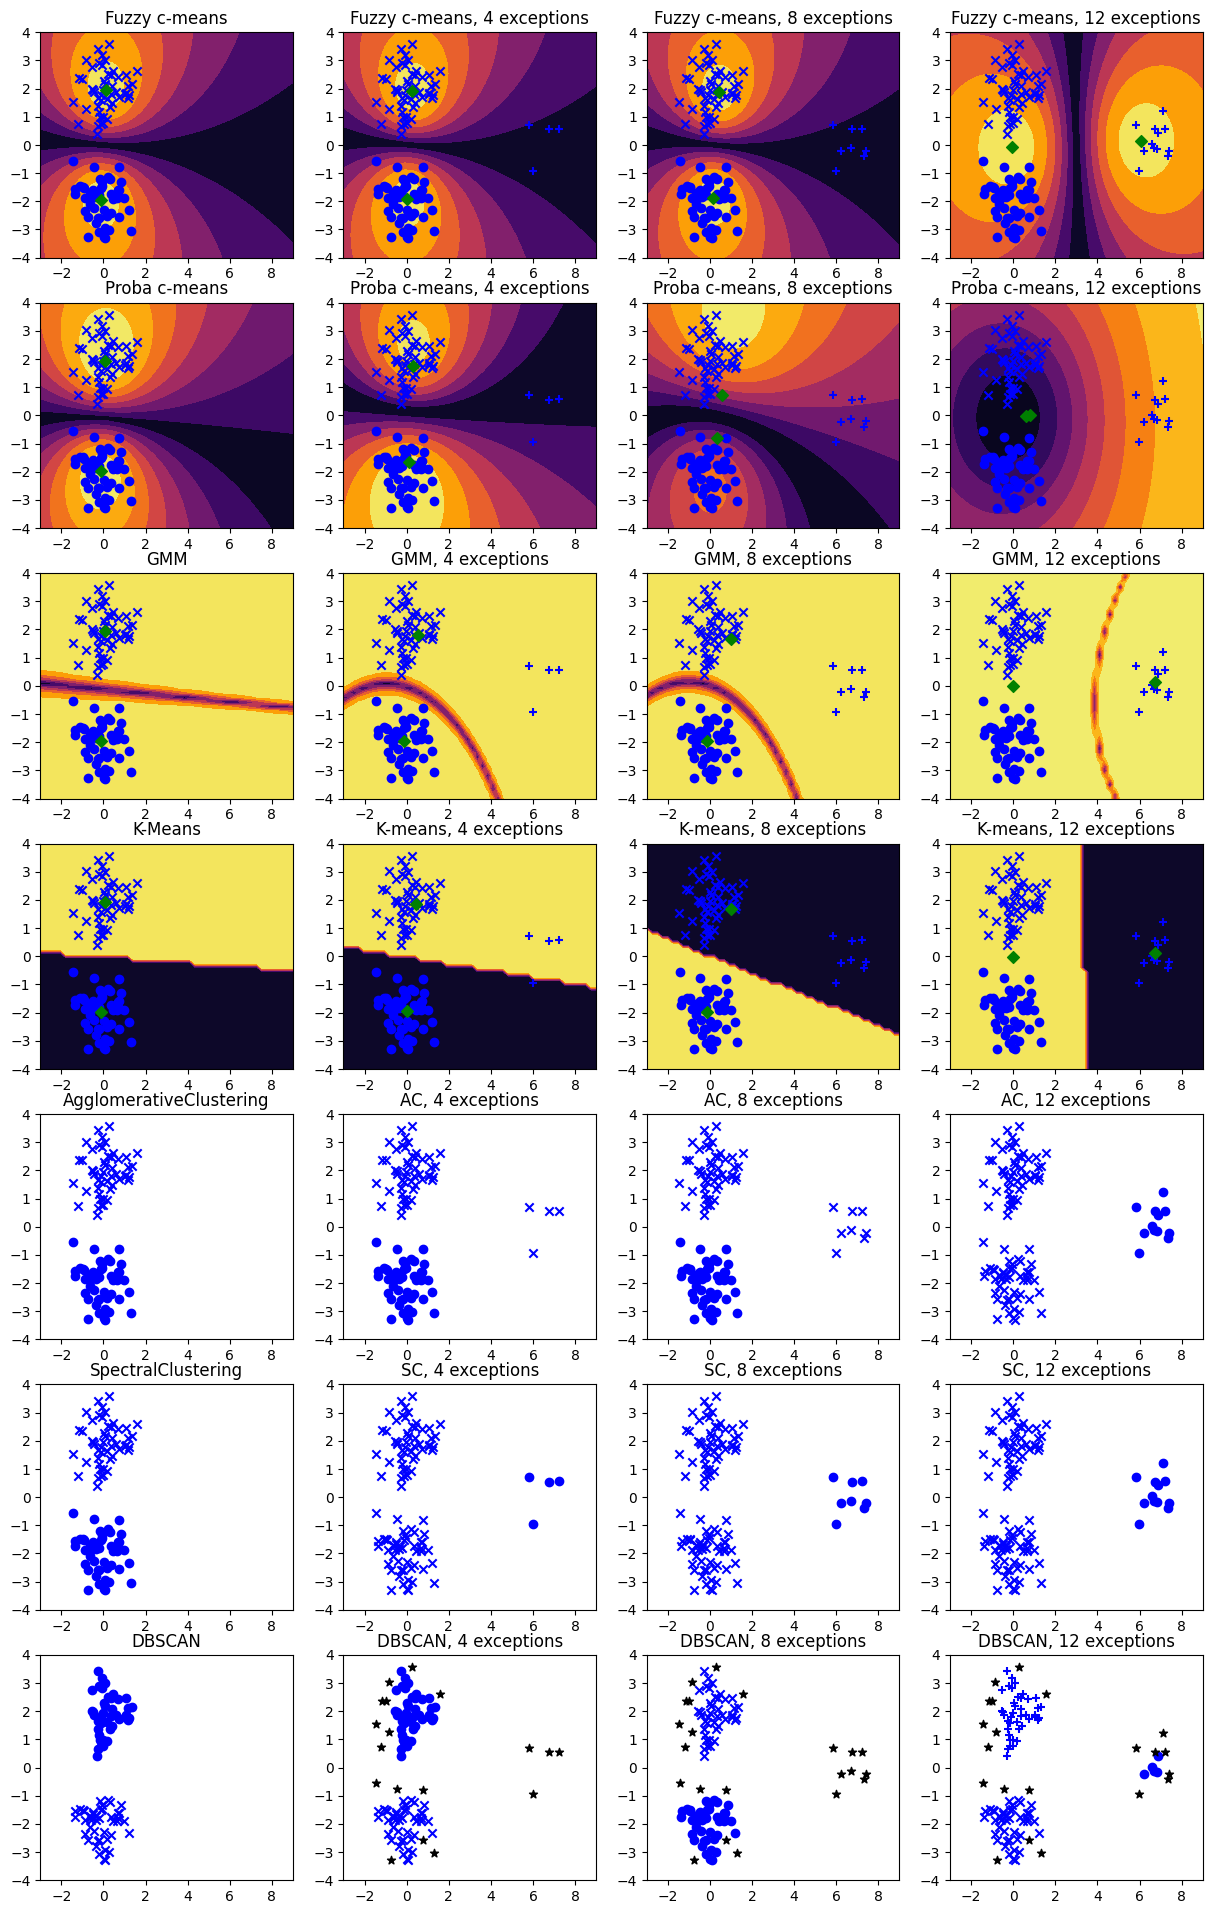

In [74]:
NB_classes = 3
TESTS = 4
rate = 4

x = np.linspace(-3.0, 9)
y = np.linspace(-4.0, 4.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

fig, ax = plt.subplots(7, TESTS, figsize=(15, TESTS*6))
data, labels = datasets.make_blobs(n_samples=[50, 50] , centers = [[0, 2], [0, -2]], shuffle=True, cluster_std = 0.7, random_state= 7)

# FUZZY
centers, U = fuzzy_c_means(2, 2, data, 0.0001, max_iter = 100)
U_init = np.ones((XX.shape[0], 2))
Z = np.max(calc_U(2, 2 , centers, XX, U_init), axis = 1)
Z = Z.reshape(X.shape)
CS = ax[0,0].contourf(X, Y, Z, cmap= 'inferno')
for i in range(NB_classes):
    ax[0,0].scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'blue')
ax[0,0].scatter(centers[:,0], centers[:,1], marker = "D", color = 'green')
ax[0,0].set_title("Fuzzy c-means")

# PROBA: 
eta = calcul_eta(U, centers, data, 2)
centers, U = proba_c_means(2, 2, data, eta, 0.001, max_iter = 100)
U_init = np.ones((XX.shape[0], 2))
Z = np.max(calc_U_proba(2, 2 , centers, XX, eta, U_init), axis = 1)
Z = Z.reshape(X.shape)
CS = ax[1,0].contourf(X, Y, Z, cmap= 'inferno')
for i in range(NB_classes):
    ax[1, 0].scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'blue')
ax[1, 0].scatter(centers[:,0], centers[:,1], marker = "D", color = 'green')
ax[1, 0].set_title("Proba c-means")


### GMM:
gm = GaussianMixture(n_components=2, random_state=42).fit(data)
pred = gm.predict_proba(XX)
Z = np.max(gm.predict_proba(XX), axis = 1)
Z = Z.reshape(X.shape)
CS = ax[2, 0].contourf(X, Y, Z, cmap= 'inferno')
centers = gm.means_
for i in range(NB_classes):
    ax[2, 0].scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'blue')
ax[2, 0].scatter(centers[:,0], centers[:,1], marker = "D", color = 'green')
ax[2, 0].set_title("GMM")

### KMEANS
km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=42).fit(data)
Z = km.predict(XX)
Z = Z.reshape(X.shape)
CS = ax[3, 0].contourf(X, Y, Z, cmap= 'inferno')
centers = km.cluster_centers_
for i in range(NB_classes):
    ax[3, 0].scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'blue')
ax[3, 0].scatter(centers[:,0], centers[:,1], marker = "D", color = 'green')
ax[3, 0].set_title("K-Means")

### Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(data)
labels = ac.labels_
for i in range(NB_classes):
    ax[4, 0].scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'blue')
ax[4, 0].set_title("AgglomerativeClustering")
ax[4, 0].set_xlim([-3.0, 9])
ax[4, 0].set_ylim([-4.0, 4.0])

### Spectral Clustering
sc = SpectralClustering(n_clusters=2).fit(data)
labels = sc.labels_
for i in range(NB_classes):
    ax[5, 0].scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'blue')
ax[5, 0].set_title("SpectralClustering")
ax[5, 0].set_xlim([-3.0, 9])
ax[5, 0].set_ylim([-4.0, 4.0])

### DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(data)
labels = dbscan.labels_
for i in range(NB_classes):
    ax[6, 0].scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'blue')
ax[6, 0].set_title("DBSCAN")
ax[6, 0].set_xlim([-3.0, 9])
ax[6, 0].set_ylim([-4.0, 4.0])



for i in range(1,TESTS):
    data, labels = datasets.make_blobs(n_samples=[50, 50, i*rate] , centers = [[0, 2], [0, -2], [7, 0]], shuffle=True, cluster_std = 0.7, random_state= 7)

    # FUZZY
    centers, U = fuzzy_c_means(2, 2, data, 0.0001, max_iter = 100)
    U_init = np.ones((XX.shape[0], 2))
    Z = np.max(calc_U(2, 2 , centers, XX, U_init), axis = 1)
    Z = Z.reshape(X.shape)
    CS = ax[0, i].contourf(X, Y, Z, cmap= 'inferno')
    for j in range(NB_classes):
        ax[0, i].scatter(data[labels == j].T[0],data[labels == j].T[1], marker= markers[j], color = 'blue')
    ax[0, i].scatter(centers[:,0], centers[:,1], marker = "D", color = 'green')
    ax[0, i].set_title("Fuzzy c-means, "+ str(i*rate) + " exceptions")

    # PROBA: 
    eta = calcul_eta(U, centers, data, 2)
    centers, U = proba_c_means(2, 2, data, eta, 0.001, max_iter = 100)
    U_init = np.ones((XX.shape[0], 2))
    Z = np.max(calc_U_proba(2, 2 , centers, XX, eta, U_init), axis = 1)
    Z = Z.reshape(X.shape)
    CS = ax[1, i].contourf(X, Y, Z, cmap= 'inferno')
    for j in range(NB_classes):
        ax[1, i].scatter(data[labels == j].T[0],data[labels == j].T[1], marker= markers[j], color = 'blue')
    ax[1, i].scatter(centers[:,0], centers[:,1], marker = "D", color = 'green')
    ax[1, i].set_title("Proba c-means, "+ str(i*rate) + " exceptions")


    ### GMM:
    gm = GaussianMixture(n_components=2, random_state=42).fit(data)
    pred = gm.predict_proba(XX)
    Z = np.max(gm.predict_proba(XX), axis = 1)
    Z = Z.reshape(X.shape)
    CS = ax[2, i].contourf(X, Y, Z, cmap= 'inferno')
    centers = gm.means_
    for j in range(NB_classes):
        ax[2, i].scatter(data[labels == j].T[0],data[labels == j].T[1], marker= markers[j], color = 'blue')
    ax[2, i].scatter(centers[:,0], centers[:,1], marker = "D", color = 'green')
    ax[2, i].set_title("GMM, "+ str(i*rate) + " exceptions")
    
    
    ### KMEANS
    km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=42).fit(data)
    Z = km.predict(XX)
    Z = Z.reshape(X.shape)
    CS = ax[3, i].contourf(X, Y, Z, cmap= 'inferno')
    centers = km.cluster_centers_
    for j in range(NB_classes):
        ax[3, i].scatter(data[labels == j].T[0],data[labels == j].T[1], marker= markers[j], color = 'blue')
    ax[3, i].scatter(centers[:,0], centers[:,1], marker = "D", color = 'green')
    ax[3, i].set_title("K-means, "+ str(i*rate) + " exceptions")
    
    ### KMEANS
    km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=42).fit(data)
    Z = km.predict(XX)
    Z = Z.reshape(X.shape)
    CS = ax[3, i].contourf(X, Y, Z, cmap= 'inferno')
    centers = km.cluster_centers_
    for j in range(NB_classes):
        ax[3, i].scatter(data[labels == j].T[0],data[labels == j].T[1], marker= markers[j], color = 'blue')
    ax[3, i].scatter(centers[:,0], centers[:,1], marker = "D", color = 'green')
    ax[3, i].set_title("K-means, "+ str(i*rate) + " exceptions")
    
    ### AgglomerativeClustering
    ac = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(data)
    labels = ac.labels_
    for j in range(NB_classes):
        ax[4, i].scatter(data[labels == j].T[0],data[labels == j].T[1], marker= markers[j], color = 'blue')
    ax[4, i].set_title("AC, "+ str(i*rate) + " exceptions")
    ax[4, i].set_xlim([-3.0, 9])
    ax[4, i].set_ylim([-4.0, 4.0])
    
    ### SpectralClustering
    sc = SpectralClustering(n_clusters=2).fit(data)
    labels = sc.labels_
    for j in range(NB_classes):
        ax[5, i].scatter(data[labels == j].T[0],data[labels == j].T[1], marker= markers[j], color = 'blue')
    ax[5, i].set_title("SC, "+ str(i*rate) + " exceptions")
    ax[5, i].set_xlim([-3.0, 9])
    ax[5, i].set_ylim([-4.0, 4.0])
    
    ### DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5).fit(data)
    labels = dbscan.labels_
    for j in range(NB_classes):
        ax[6, i].scatter(data[labels == j].T[0],data[labels == j].T[1], marker= markers[j], color = 'blue')
    ax[6, i].scatter(data[labels == -1].T[0],data[labels == -1].T[1], marker= markers[-1], color = 'black')
    ax[6, i].set_title("DBSCAN, "+ str(i*rate) + " exceptions")
    ax[6, i].set_xlim([-3.0, 9])
    ax[6, i].set_ylim([-4.0, 4.0])

plt.show()



### Q5 - Algorithm Stability
For this section we propose data composed of a number of known gaussians and a mean and std accuracy scoring to evaluate the algorithm's stability.

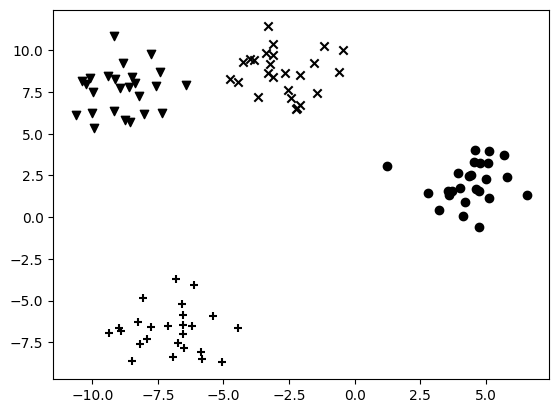

In [38]:
NB_classes = 4
markers = ['x', 'o', '+', "v", "*"]
data, labels = datasets.make_blobs(n_samples=100, centers = NB_classes, shuffle=True, random_state=42, cluster_std = 1.3)
for i in range(NB_classes):
    plt.scatter(data[labels == i].T[0],data[labels == i].T[1], marker= markers[i], color = 'black')

In [39]:
def score(y,y_pred):
    return np.sum((y == y_pred).astype(int))

NB_ALGOS = 7
NB_ITER = 100
accuracies = np.zeros((NB_ALGOS, NB_ITER))
for i in range(NB_ITER):
    print(f"iteration:{i}")
    # FUZZY
    centers, U = fuzzy_c_means(NB_classes, 2, data, 0.0001, max_iter = 100)
    pred = np.argmax(U, axis = 1)
    accuracies[0,i] = score(labels,pred)

    # PROBA: 
    eta = calcul_eta(U, centers, data, 2)
    centers, U = proba_c_means(NB_classes, 2, data, eta, 0.001, max_iter = 100)
    pred = np.argmax(U, axis = 1)
    accuracies[1,i] = score(labels,pred)

    ### GMM:
    gm = GaussianMixture(n_components=NB_classes).fit(data)
    pred = gm.predict(data)
    accuracies[2,i] = score(labels,pred)

    ### KMEANS
    km = KMeans(n_clusters=NB_classes, init='random', n_init=10, max_iter=300, tol=0.0001, verbose=0).fit(data)
    pred = km.predict(data)
    accuracies[3,i] = score(labels,pred)

    ### Agglomerative Clustering
    ac = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(data)
    pred = ac.labels_
    accuracies[4,i] = score(labels,pred)

    ### Spectral Clustering
    sc = SpectralClustering(n_clusters=2).fit(data)
    pred = sc.labels_
    accuracies[5,i] = score(labels,pred)

    ### DBSCAN
    dbscan = DBSCAN(eps=2, min_samples=5).fit(data)
    pred = dbscan.labels_
    accuracies[6,i] = score(labels,pred)
print(accuracies/ NB_ITER)

iteration:0
iteration:1
iteration:2
iteration:3
iteration:4
iteration:5
iteration:6
iteration:7
iteration:8
iteration:9
iteration:10
iteration:11
iteration:12
iteration:13
iteration:14
iteration:15
iteration:16
iteration:17
iteration:18
iteration:19
iteration:20
iteration:21
iteration:22
iteration:23
iteration:24
iteration:25
iteration:26
iteration:27
iteration:28
iteration:29
iteration:30
iteration:31
iteration:32
iteration:33
iteration:34
iteration:35
iteration:36
iteration:37
iteration:38
iteration:39
iteration:40
iteration:41
iteration:42
iteration:43
iteration:44
iteration:45
iteration:46
iteration:47
iteration:48
iteration:49
iteration:50
iteration:51
iteration:52
iteration:53
iteration:54
iteration:55
iteration:56
iteration:57
iteration:58
iteration:59
iteration:60
iteration:61
iteration:62
iteration:63
iteration:64
iteration:65
iteration:66
iteration:67
iteration:68
iteration:69
iteration:70
iteration:71
iteration:72
iteration:73
iteration:74
iteration:75
iteration:76
iteration

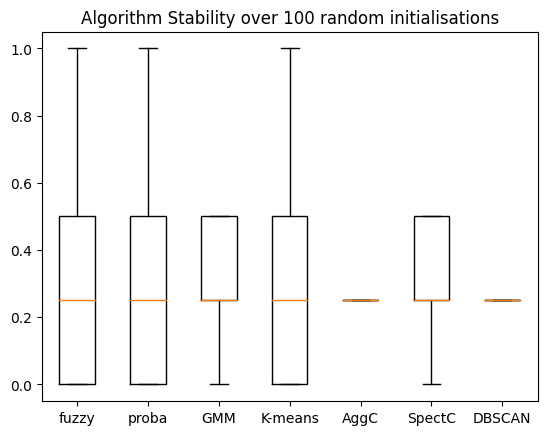

[1.   1.   0.5  1.   0.25 0.5  0.25]
[0.   0.   0.   0.   0.25 0.   0.25]
[0.2384 0.2873 0.2875 0.255  0.25   0.3    0.25  ]
[0.24099676 0.26095921 0.19485572 0.23711811 0.         0.18027756
 0.        ]


In [40]:
BoxName = ['fuzzy','proba','GMM', 'K-means', 'AggC', 'SpectC', 'DBSCAN']
plt.title("Algorithm Stability over 100 random initialisations")
plt.boxplot((accuracies/ NB_ITER).T)
pylab.xticks([1,2,3,4,5,6,7], BoxName)
plt.show()

max = np.max(accuracies/ NB_ITER, axis = 1)
min = np.min(accuracies/ NB_ITER, axis = 1)
means = np.mean(accuracies/ NB_ITER, axis = 1)
std = np.std(accuracies/ NB_ITER, axis = 1)

print(max)
print(min)
print(means)
print(std)